In [1]:
import itk
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from ca_iss_app.ca_iss_io import read_dicom_files
from ca_iss_app.ca_iss_features import convert_image_sitk_to_itk, convert_image_itk_to_sitk, cast_image

In [196]:
preOpDir = 'D:\skola\DP\dp_source\input_files\pacient_11\ct_zavadec\ScalarVolume_93'
intraOpDir = 'D:\skola\DP\dp_source\input_files\pacient_11\ct\ScalarVolume_762'

preOpVolume = read_dicom_files(preOpDir)
intraOpVolume = read_dicom_files(intraOpDir)

In [4]:
input_image_type = itk.Image[itk.SS, 3]
output_image_type = itk.Image[itk.UC, 3]

image_filter = itk.ResampleImageFilter[input_image_type, input_image_type].New()
image_filter.SetDefaultPixelValue(0)

transform = itk.CenteredEuler3DTransform[itk.D].New()
transform.SetComputeZYX(True)

interpolator = itk.itkRayCastInterpolateImageFunctionPython.itkRayCastInterpolateImageFunctionISS3D.New()

rescale_filter = sitk.RescaleIntensityImageFilter()

cast_filter = sitk.CastImageFilter()

In [193]:
def generate_drr(ct_volume: sitk.Image,
                 view: int = 0,
                 src_img_dist: float = 1000.0,
                 drr_size: tuple[int, int] = (512, 512),
                 threshold: float = 200, 
                 ct_source: str = "preop") -> sitk.Image | None:
    
    itk_volume = convert_image_sitk_to_itk(ct_volume) # convert sitk image to itk image
    image_filter.SetInput(itk_volume)

    rotation_x = None
    rotation_z = None
    
    match view:
        case 0: # ap view
            rotation_x = -90. # in degrees
            rotation_z = 0.
        case 1: # lateral left view
            rotation_z = 90.
        case 2: # lateral right view
            rotation_z = -90.
        case 3: # pelvic inlet view
            rotation_x = -135.
        case _:
            print("Neznámý pohled")
            return None
    
    match ct_source:
        case "intraop":
            random_angle_x = np.random.normal(0., 1.) # in degrees
            random_angle_y = np.random.normal(0., 1.)
            random_angle_z = np.random.normal(0., 1.)
        case "preop":
            random_angle_x = random_angle_y = random_angle_z = 0.
        case _:
            print("Neznámý CT zdroj")
            return None
    
    transform.SetRotation(np.deg2rad(rotation_x + random_angle_x), 
                          np.deg2rad(random_angle_y), 
                          np.deg2rad(rotation_z + random_angle_z))

    ct_origin = itk_volume.GetOrigin()
    ct_spacing = itk_volume.GetSpacing()
    ct_size = itk_volume.GetLargestPossibleRegion().GetSize()
        
    ct_center = (ct_origin[0] + (ct_size[0] / 2.0) * ct_spacing[0],
                 ct_origin[1] + (ct_size[1] / 2.0) * ct_spacing[1],
                 ct_origin[2] + (ct_size[2] / 2.0) * ct_spacing[2])
    
    transform.SetCenter(ct_center)
    interpolator.SetTransform(transform)
    interpolator.SetThreshold(threshold)
    
    drr_9inch_spacing = 0.2286
    
    # sampling scale factor for images bigger than default
    default_drr_size = 512 # x, y size
    spacing_scale_factor = (drr_size[0] / default_drr_size,
                            drr_size[1] / default_drr_size)
    
    match ct_source:
        case "preop":
            drr_spacing = (ct_spacing[0] / spacing_scale_factor[0], 
                           ct_spacing[2] / spacing_scale_factor[1],
                           1.0)
        case "intraop":
            drr_spacing = (drr_9inch_spacing * spacing_scale_factor[0],
                           drr_9inch_spacing * spacing_scale_factor[1], 
                           1.0)
        case _:
            print("Neznámý CT zdroj")
            return None
            
    focal_point = (ct_center[0],
                   ct_center[1],
                   ct_center[2] - ((ct_size[1] / 2.0) * ct_spacing[1]) - src_img_dist)
    interpolator.SetFocalPoint(focal_point)

    drr_image_size = itk.Size[3]((drr_size[0],
                                  drr_size[1],
                                  1))

    drr_origin = (ct_origin[0],
                  ct_origin[1],
                  ct_origin[2] + (ct_size[1] * ct_spacing[1]) - 50)
    
    image_filter.SetSize(drr_image_size)
    image_filter.SetOutputSpacing(drr_spacing)
    image_filter.SetInterpolator(interpolator)
    image_filter.SetTransform(transform)
    image_filter.SetOutputOrigin(drr_origin)
    
    return convert_image_itk_to_sitk(image_filter.GetOutput())

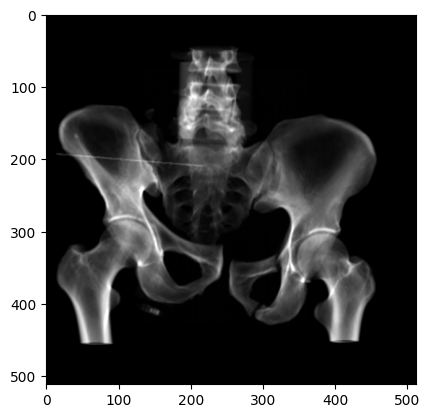

In [199]:
preOpDrrImage = generate_drr(preOpVolume, view=0, src_img_dist=1000.0, drr_size=(512, 512), threshold=100, 
                             ct_source="preop")

preOpDrrCasted = cast_image(preOpDrrImage, "uint8")
preOpDrrArray = sitk.GetArrayFromImage(preOpDrrImage)
plt.imshow(preOpDrrArray[0, :, :], cmap="gray")

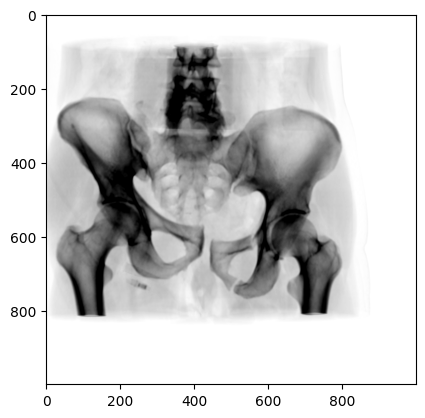

In [206]:
intraOpDrrImage = generate_drr(intraOpVolume, view=0, src_img_dist=1000.0, drr_size=(1000, 1000), 
                               threshold=-25, ct_source="intraop")

drrImageInverted = sitk.InvertIntensity(intraOpDrrImage)
drrImageInvertedArray = sitk.GetArrayFromImage(drrImageInverted)
plt.imshow(drrImageInvertedArray[0, :, :], cmap="gray")

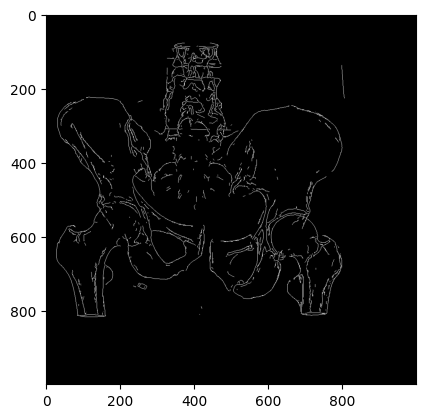

In [215]:
drrImageInvertedEdges = sitk.CannyEdgeDetection(sitk.Cast(drrImageInverted, sitk.sitkFloat32), lowerThreshold=800, 
                                         upperThreshold=900)

drrEdgesInvertedArray = sitk.GetArrayFromImage(drrImageInvertedEdges)
plt.imshow(drrEdgesInvertedArray[0, :, :], cmap="gray")